In [27]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import re
import time
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AdamW
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("balanced_hybrid_sarcasm_dataset_10000.csv")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
df["Processed_Text"] = df["Text"].apply(preprocess_text)

In [6]:
df

,Text,Source,Language,label,Processed_Text
0,Anyone 2025❤️‍🩹☺️,YouTube,cs,0,anyone 2025
1,LIL C@NCER,Reddit,pa,1,lil cncer
2,Y’all xoomers can kiss my ass,Reddit,lb,0,yall xoomers can kiss my ass
3,Here from jynxzi fan mail😅😅,YouTube,fy,0,here from jynxzi fan mail
4,i got an add get rekt,YouTube,sk,0,i got an add get rekt
...,...,...,...,...,...
83995,vim pelo story do thiago finch 😂,YouTube,pt,1,vim pelo story do thiago finch
83996,@Beluga,YouTube,el,1,beluga
83997,​ ​,YouTube,km,1,
83998,Somewhere Shinji,Reddit,en,0,somewhere shinji


In [7]:
model_name = "sentence-transformers/LaBSE"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [8]:
def get_labse_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

In [9]:
tqdm.pandas(desc="Generating Embeddings")
embeddings = df["Processed_Text"].progress_apply(get_labse_embeddings)

Generating Embeddings: 100%|██████████| 84000/84000 [1:13:50<00:00, 18.96it/s]


In [21]:
embeddings.to_pickle("final_embeddings.pkl")

In [10]:
embeddings_df = pd.DataFrame(embeddings.tolist(), columns=[f"emb_{i}" for i in range(embeddings.iloc[0].shape[0])])
df = pd.concat([df, embeddings_df], axis=1)

In [11]:
print(df.head())

                            Text   Source Language  label  \
0              Anyone 2025❤️‍🩹☺️  YouTube       cs      0   
1                     LIL C@NCER   Reddit       pa      1   
2  Y’all xoomers can kiss my ass   Reddit       lb      0   
3    Here from jynxzi fan mail😅😅  YouTube       fy      0   
4          i got an add get rekt  YouTube       sk      0   

                 Processed_Text     emb_0     emb_1     emb_2     emb_3  \
0                   anyone 2025  0.346003 -0.642110  0.708753 -0.388275   
1                     lil cncer  0.199236  0.197432 -0.327764  0.075199   
2  yall xoomers can kiss my ass  0.448246  0.679574  0.656879 -0.119002   
3     here from jynxzi fan mail  0.251159  0.245812 -0.001551 -0.417869   
4         i got an add get rekt  1.075808 -0.345336  1.446997 -0.289777   

      emb_4  ...   emb_758   emb_759   emb_760   emb_761   emb_762   emb_763  \
0  0.251008  ...  0.899158 -0.339041  0.137452  0.212549  0.308469  0.278903   
1  0.650867  ...  0.51

In [12]:
X = df.iloc[:, 5:] 
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (67200, 768)
Testing Set Shape: (16800, 768)


In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [16]:
y_pred = model.predict(X_test)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8905357142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      6369
           1       0.87      0.97      0.92     10431

    accuracy                           0.89     16800
   macro avg       0.91      0.86      0.88     16800
weighted avg       0.90      0.89      0.89     16800



In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm_model = SGDClassifier(loss='hinge', max_iter=1, tol=None, random_state=42, warm_start=True)

print("Training the SVM model with progress bar...")
for epoch in tqdm(range(100), desc="Training Progress", unit="epoch"):
    svm_model.fit(X_train_scaled, y_train)

print("Training completed!")

Training the SVM model with progress bar...


Training Progress: 100%|██████████| 100/100 [00:25<00:00,  3.97epoch/s]

Training completed!


In [23]:
y_pred_svm = svm_model.predict(X_test)

/home/manthan/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


In [24]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm}")

print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

Accuracy (SVM): 0.6233928571428572
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.89      0.01      0.01      6369
           1       0.62      1.00      0.77     10431

    accuracy                           0.62     16800
   macro avg       0.76      0.50      0.39     16800
weighted avg       0.72      0.62      0.48     16800



In [28]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, verbose=0)

print("Training the Random Forest model with progress bar...")
for _ in tqdm(range(1), desc="Fitting the model", unit="step"):
    rf_clf.fit(X_train, y_train)
    time.sleep(0.1)

rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("\nAccuracy (Random Forest):", rf_accuracy)
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_pred))

Training the Random Forest model with progress bar...


Fitting the model: 100%|██████████| 1/1 [00:52<00:00, 52.17s/step]



Accuracy (Random Forest): 0.8991071428571429
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.96      0.76      0.85      6369
           1       0.87      0.98      0.92     10431

    accuracy                           0.90     16800
   macro avg       0.92      0.87      0.89     16800
weighted avg       0.91      0.90      0.90     16800



In [29]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', verbose=0)

print("Training the XGBoost model with progress bar...")
for _ in tqdm(range(1), desc="Fitting the model", unit="step"):
    xgb_clf.fit(X_train, y_train, verbose=True)

xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("\nAccuracy (XGBoost):", xgb_accuracy)
print("Classification Report (XGBoost):\n", classification_report(y_test, xgb_pred))

Training the XGBoost model with progress bar...


Fitting the model:   0%|          | 0/1 [00:00<?, ?step/s]/home/manthan/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:18:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
Fitting the model: 100%|██████████| 1/1 [00:23<00:00, 23.72s/step]



Accuracy (XGBoost): 0.8994047619047619
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.76      0.85      6369
           1       0.87      0.98      0.92     10431

    accuracy                           0.90     16800
   macro avg       0.92      0.87      0.89     16800
weighted avg       0.91      0.90      0.90     16800



In [30]:
nb_clf = GaussianNB()

print("Training the Naive Bayes model with progress bar...")
for _ in tqdm(range(1), desc="Fitting the model", unit="step"):
    nb_clf.fit(X_train, y_train)
    time.sleep(0.1)  # Simulate progress (optional)
nb_pred = nb_clf.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print("\nAccuracy (Naive Bayes - Gaussian):", nb_accuracy)
print("Classification Report (Naive Bayes - Gaussian):\n", classification_report(y_test, nb_pred))

Training the Naive Bayes model with progress bar...


Fitting the model: 100%|██████████| 1/1 [00:00<00:00,  1.58step/s]


Accuracy (Naive Bayes - Gaussian): 0.732202380952381
Classification Report (Naive Bayes - Gaussian):
               precision    recall  f1-score   support

           0       0.61      0.80      0.69      6369
           1       0.85      0.69      0.76     10431

    accuracy                           0.73     16800
   macro avg       0.73      0.74      0.73     16800
weighted avg       0.76      0.73      0.74     16800



In [31]:
X = df['Processed_Text'].values
y = df['label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [33]:
max_len = 50  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [34]:
vocab_size = len(tokenizer.word_index) + 1

In [35]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/home/manthan/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-20 22:20:28.459014: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 118s 53ms/step - accuracy: 0.8168 - loss: 0.3597 - val_accuracy: 0.8927 - val_loss: 0.2018
Epoch 2/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 114s 54ms/step - accuracy: 0.8987 - loss: 0.1880 - val_accuracy: 0.8949 - val_loss: 0.1962
Epoch 3/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 116s 55ms/step - accuracy: 0.9024 - loss: 0.1777 - val_accuracy: 0.8957 - val_loss: 0.2021
Epoch 4/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.9049 - loss: 0.1700 - val_accuracy: 0.8968 - val_loss: 0.2066
Epoch 5/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 146s 69ms/step - accuracy: 0.9048 - loss: 0.1719 - val_accuracy: 0.8970 - val_loss: 0.2101


In [40]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Accuracy (BiLSTM): {accuracy}")
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("Classification Report (BiLSTM):\n", classification_report(y_test, y_pred))

525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8961 - loss: 0.2018
Accuracy (BiLSTM): 0.8948809504508972
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step
Classification Report (BiLSTM):
               precision    recall  f1-score   support

           0       0.96      0.76      0.85      6369
           1       0.87      0.98      0.92     10431

    accuracy                           0.89     16800
   macro avg       0.91      0.87      0.88     16800
weighted avg       0.90      0.89      0.89     16800



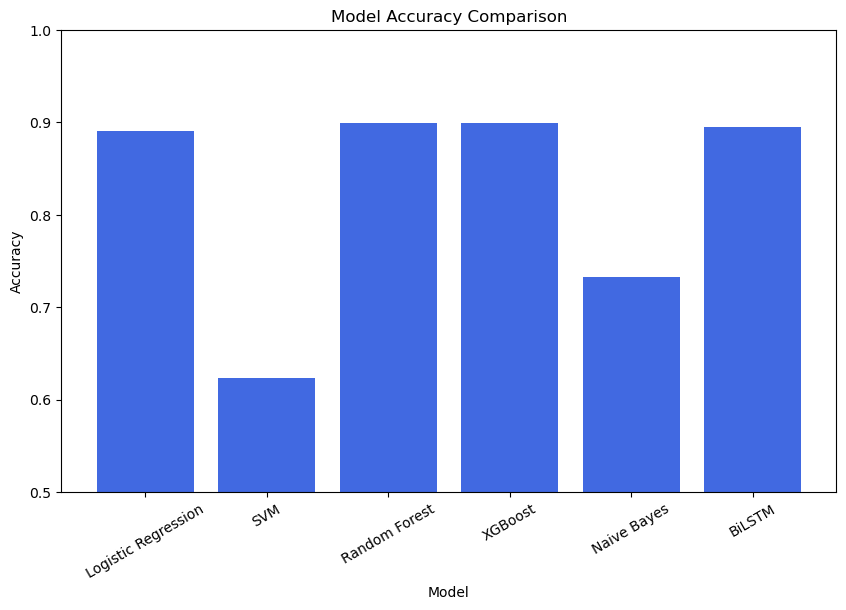

In [41]:
import matplotlib.pyplot as plt

# Model names and their respective accuracies
models = [
    "Logistic Regression", 
    "SVM", 
    "Random Forest", 
    "XGBoost", 
    "Naive Bayes", 
    "BiLSTM"
]
accuracies = [
    0.8905,  # Logistic Regression
    0.6234,  # SVM
    0.8991,  # Random Forest
    0.8994,  # XGBoost
    0.7322,  # Naive Bayes
    0.8949   # BiLSTM
]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='royalblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.5, 1.0)  # Set y-axis range from 0.5 to 1.0 for better comparison
plt.xticks(rotation=30)
plt.show()
